In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


### Load Data

In [2]:
train_data=pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv")
test_data=pd.read_csv("/kaggle/input/playground-series-s5e7/test.csv")
train_data.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [3]:
train_data = train_data.drop_duplicates()

In [ ]:
train_data.shape

In [ ]:
test_data.shape

In [ ]:
train_data.describe()


In [ ]:
train_data.info()

In [4]:
train_data.drop('id', axis=1, inplace=True)
test_data.drop('id', axis=1, inplace=True)

In [5]:
# Check for missing values in the training data
print("Missing values in training data:")
print(train_data.isnull().sum())

# Check for missing values in the test data
print("\nMissing values in test data:")
print(test_data.isnull().sum())

Missing values in training data:
Time_spent_Alone             1190
Stage_fear                   1893
Social_event_attendance      1180
Going_outside                1466
Drained_after_socializing    1149
Friends_circle_size          1054
Post_frequency               1264
Personality                     0
dtype: int64

Missing values in test data:
Time_spent_Alone             425
Stage_fear                   598
Social_event_attendance      397
Going_outside                466
Drained_after_socializing    432
Friends_circle_size          350
Post_frequency               408
dtype: int64


In [6]:
num_cols = train_data.select_dtypes(include=['float64', 'int64']).columns.tolist()
obj_cols = train_data.select_dtypes(include=['object']).columns.tolist()

In [7]:
obj_cols.remove('Personality')

In [ ]:
train_data["Stage_fear"].unique()

In [ ]:
train_data["Drained_after_socializing"].unique()

### Data Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
plt.figure(figsize=(10, 5))
for i, col in enumerate(obj_cols):
    plt.subplot(1, 2, i + 1)
    sns.countplot(x=train_data[col])
    plt.title(f'Distribution of {col}')
    plt.xticks([0, 1], ['No', 'Yes']) 
plt.tight_layout()
plt.show()

In [ ]:
train_data[obj_cols].describe()

In [ ]:
plt.figure(figsize=(15, 10))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(y=train_data[col])
    plt.title(f'Box plot of {col}')
plt.tight_layout()
plt.show()

### Handling Missing Values

In [8]:
for col in obj_cols:
    # Map 'Yes' to 1, 'No' to 0, and NaN/others to NaN for imputation
    mapping = {'Yes': 1, 'No': 0}
    train_data[col] = train_data[col].map(mapping)
    test_data[col] = test_data[col].map(mapping)

    # Impute missing values with the mode from the training set
    mode_val_train = train_data[col].mode()[0] 
    train_data[col].fillna(mode_val_train, inplace=True)
    test_data[col].fillna(mode_val_train, inplace=True) 

/tmp/ipykernel_36/2925108889.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].fillna(mode_val_train, inplace=True)
/tmp/ipykernel_36/2925108889.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

In [9]:
for col in num_cols:
    # Ensure they are numeric, coercing errors to NaN
    train_data[col] = pd.to_numeric(train_data[col], errors='coerce')
    test_data[col] = pd.to_numeric(test_data[col], errors='coerce')

    # Impute missing values with the median from the training set
    median_val_train = train_data[col].median()
    train_data[col].fillna(median_val_train, inplace=True)
    test_data[col].fillna(median_val_train, inplace=True) 


/tmp/ipykernel_36/1271741955.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data[col].fillna(median_val_train, inplace=True)
/tmp/ipykernel_36/1271741955.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

In [10]:
# Check for missing values in the training data
print("Missing values in training data:")
print(train_data.isnull().sum())

# Check for missing values in the test data
print("\nMissing values in test data:")
print(test_data.isnull().sum())

Missing values in training data:
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64

Missing values in test data:
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
dtype: int64


In [ ]:
train_data.describe()

In [ ]:
train_data.info()

In [ ]:
print(obj_cols)

### Outlier Detection and Handling using IQR Method

In [11]:
def cap_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers_before = df[(df[column] < lower_bound) | (df[column] > upper_bound)].shape[0]
    print(f"Column: {column}, Outliers before capping: {outliers_before}")

    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

In [13]:
for col in num_cols:
    train_df = cap_outliers_iqr(train_data.copy(), col) 


Column: Time_spent_Alone, Outliers before capping: 1653
Column: Social_event_attendance, Outliers before capping: 0
Column: Going_outside, Outliers before capping: 0
Column: Friends_circle_size, Outliers before capping: 0
Column: Post_frequency, Outliers before capping: 0


In [ ]:
train_df.info()

In [14]:
mapping = {'Introvert': 1, 'Extrovert': 0}
train_df["Personality"] = train_data["Personality"].map(mapping)


In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           18524 non-null  float64
 1   Stage_fear                 18524 non-null  float64
 2   Social_event_attendance    18524 non-null  float64
 3   Going_outside              18524 non-null  float64
 4   Drained_after_socializing  18524 non-null  float64
 5   Friends_circle_size        18524 non-null  float64
 6   Post_frequency             18524 non-null  float64
 7   Personality                18524 non-null  int64  
dtypes: float64(7), int64(1)
memory usage: 1.1 MB


In [16]:
test_data.info()
test_df=test_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6175 entries, 0 to 6174
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Time_spent_Alone           6175 non-null   float64
 1   Stage_fear                 6175 non-null   float64
 2   Social_event_attendance    6175 non-null   float64
 3   Going_outside              6175 non-null   float64
 4   Drained_after_socializing  6175 non-null   float64
 5   Friends_circle_size        6175 non-null   float64
 6   Post_frequency             6175 non-null   float64
dtypes: float64(7)
memory usage: 337.8 KB


### Feature Engineering

In [17]:
train_df["sociality"] = train_df["Friends_circle_size"]*train_df["Post_frequency"]*train_df["Social_event_attendance"]
test_df["sociality"] = test_df["Friends_circle_size"]*test_df["Post_frequency"]*test_df["Social_event_attendance"]

In [18]:
train_df["aloneratio"] = train_df["Time_spent_Alone"]/(train_df["Post_frequency"]+1)
test_df["aloneratio"] = test_df["Time_spent_Alone"]/(test_df["Post_frequency"]+1)

In [ ]:
# median_val_train = train_df["aloneratio"].median()
# train_df["aloneratio"].fillna(median_val_train, inplace=True)
# test_df["aloneratio"].fillna(median_val_train, inplace=True) 

In [ ]:
train_df.info()

### Evaluation

In [19]:
X = train_df.drop(['Personality'], axis=1) 
y = train_df['Personality']

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report,confusion_matrix, roc_auc_score, roc_curve)
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) 

In [ ]:
X_train.info()

In [22]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n===== {name} =====")
    print(classification_report(y_test, y_pred, digits=4))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("ROC AUC:", roc_auc_score(y_test, y_proba))

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid()


### NN 

In [23]:
input_shape = X_train.shape[1]

In [ ]:
input_shape

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

2025-07-30 06:32:40.233225: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753857160.566765      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753857160.654295      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [56]:
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor the validation loss
    patience=10,                 # Number of epochs with no improvement after which training will be stopped
    min_delta=0.00,             # Minimum change in the monitored quantity to qualify as an improvement
    restore_best_weights=True,   # Restore model weights from the epoch with the best monitored value
    verbose=1                    # Show messages when stopping
)

### Model

In [ ]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(input_shape,)),
    layers.Dropout(0.3), # Dropout layer to prevent overfitting
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3), # Another dropout layer
    layers.Dense(1, activation='sigmoid')
])

### More Wide Model

In [ ]:
model = keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(input_shape,)),
    layers.Dropout(0.3), # Dropout layer to prevent overfitting
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3), # Another dropout layer
    layers.Dense(1, activation='sigmoid')
])

### More Deep Model

In [45]:
model = keras.Sequential([
    layers.Dense(128, activation='relu', input_shape=(input_shape,)),
    layers.Dropout(0.3), # Dropout layer to prevent overfitting
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3), # Another dropout layer
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3), # Another dropout layer
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3), # Another dropout layer
    layers.Dense(1, activation='sigmoid')

])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Using ELU

In [57]:
model = keras.Sequential([
    # Input layer and first hidden layer
    # Apply Dense layer without activation first
    layers.Dense(128, input_shape=(input_shape,)),
    layers.ELU(alpha=1.0), # Then add ELU as a separate layer
    layers.Dropout(0.3),

    layers.Dense(64), 
    layers.ELU(alpha=1.0), 
    layers.Dropout(0.3),

    layers.Dense(32),
    layers.ELU(alpha=1.0),
    layers.Dropout(0.3),

    layers.Dense(32),
    layers.ELU(alpha=1.0),
    layers.Dropout(0.3),
    
    layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [58]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 128)            │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu (ELU)                       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_1 (ELU)                     │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_2 (ELU)                     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ elu_3 (ELU)                     │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,705 (49.63 KB)

 Trainable params: 12,705 (49.63 KB)

 Non-trainable params: 0 (0.00 B)

### Training

Epoch 1/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8833 - loss: 1.1390 - val_accuracy: 0.9652 - val_loss: 0.2014
Epoch 2/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9329 - loss: 0.2890 - val_accuracy: 0.9668 - val_loss: 0.1635
Epoch 3/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9504 - loss: 0.2228 - val_accuracy: 0.9695 - val_loss: 0.1426
Epoch 4/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9603 - loss: 0.1803 - val_accuracy: 0.9700 - val_loss: 0.1409
Epoch 5/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9610 - loss: 0.1750 - val_accuracy: 0.9703 - val_loss: 0.1296
Epoch 6/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9666 - loss: 0.1575 - val_accuracy: 0.9709 - val_loss: 0.1288
Epoch 7/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9646 - loss: 0.1607 - val_accuracy: 0.9706 - val_loss: 0.1311
Epoch 8/100
464/464 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9672 - loss: 0.1535 - val_accu

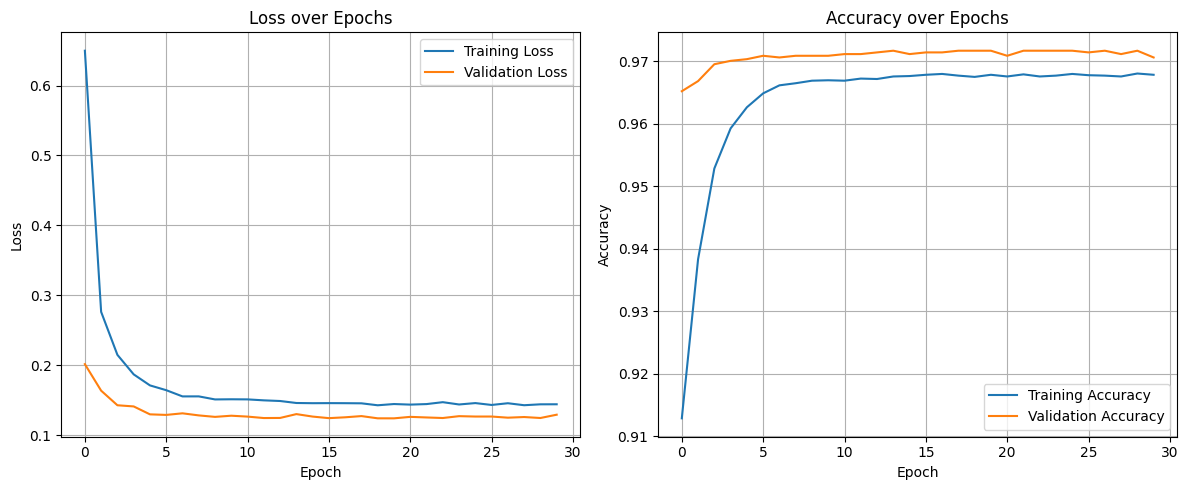

In [60]:
history = model.fit(X_train, y_train,
                    epochs=100, # You can adjust this number
                    batch_size=32, # You can adjust this number
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping],
                    verbose=1) # 1 for progress bar, 0 for silent

# Plot training history (loss and accuracy)
def plot_history(history):
    history_df = pd.DataFrame(history.history)
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history_df['loss'], label='Training Loss')
    plt.plot(history_df['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history_df['accuracy'], label='Training Accuracy')
    plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_history(history)

### Predictions

In [ ]:
test_data.shape

In [ ]:
X_train.shape

In [61]:
predictions = model.predict(test_data)

193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


### Submission

In [62]:
submission = pd.read_csv('/kaggle/input/playground-series-s5e7/sample_submission.csv')
submission

,id,Personality
0,18524,Extrovert
1,18525,Extrovert
2,18526,Extrovert
3,18527,Extrovert
4,18528,Extrovert
...,...,...
6170,24694,Extrovert
6171,24695,Extrovert
6172,24696,Extrovert
6173,24697,Extrovert


In [63]:
test_predictions_binary = (predictions > 0.5).astype(int)

In [64]:
test_predictions_binary

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [1]])

In [65]:
submission["Personality"]=test_predictions_binary

In [66]:
mapping = {1:'Introvert', 0:'Extrovert'}
submission["Personality"] = submission["Personality"].map(mapping)

In [68]:
submission.to_csv("submission_NN_ELUActivation.csv",index=False)